# Modelo para predicción de prestaciones en agencia de seguros y ofuscación de datos

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
pip install scikit-learn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from scipy.spatial import distance

import math

from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [4]:
try :
  df = pd.read_csv('/datasets/insurance_us.csv')
except:
  df = pd.read_csv('/content/drive/MyDrive/practicum/Sprint11/insurance_us.csv')


Renombramos las columnas para que el código se vea más coherente con su estilo.

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2173,1,29.0,32000.0,4,0
257,0,37.0,52500.0,3,0
977,1,20.0,38500.0,1,0
997,1,39.0,28500.0,4,0
1971,1,39.0,33400.0,1,0
3468,0,19.0,41400.0,0,0
1714,1,43.0,40500.0,1,1
1301,1,20.0,52300.0,1,0
1786,1,27.0,42100.0,0,0
595,0,35.0,37400.0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [8]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial
df['age'] = df['age'].astype('int')
# escribe tu conversión aquí si lo deseas:

In [9]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [10]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?

In [11]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

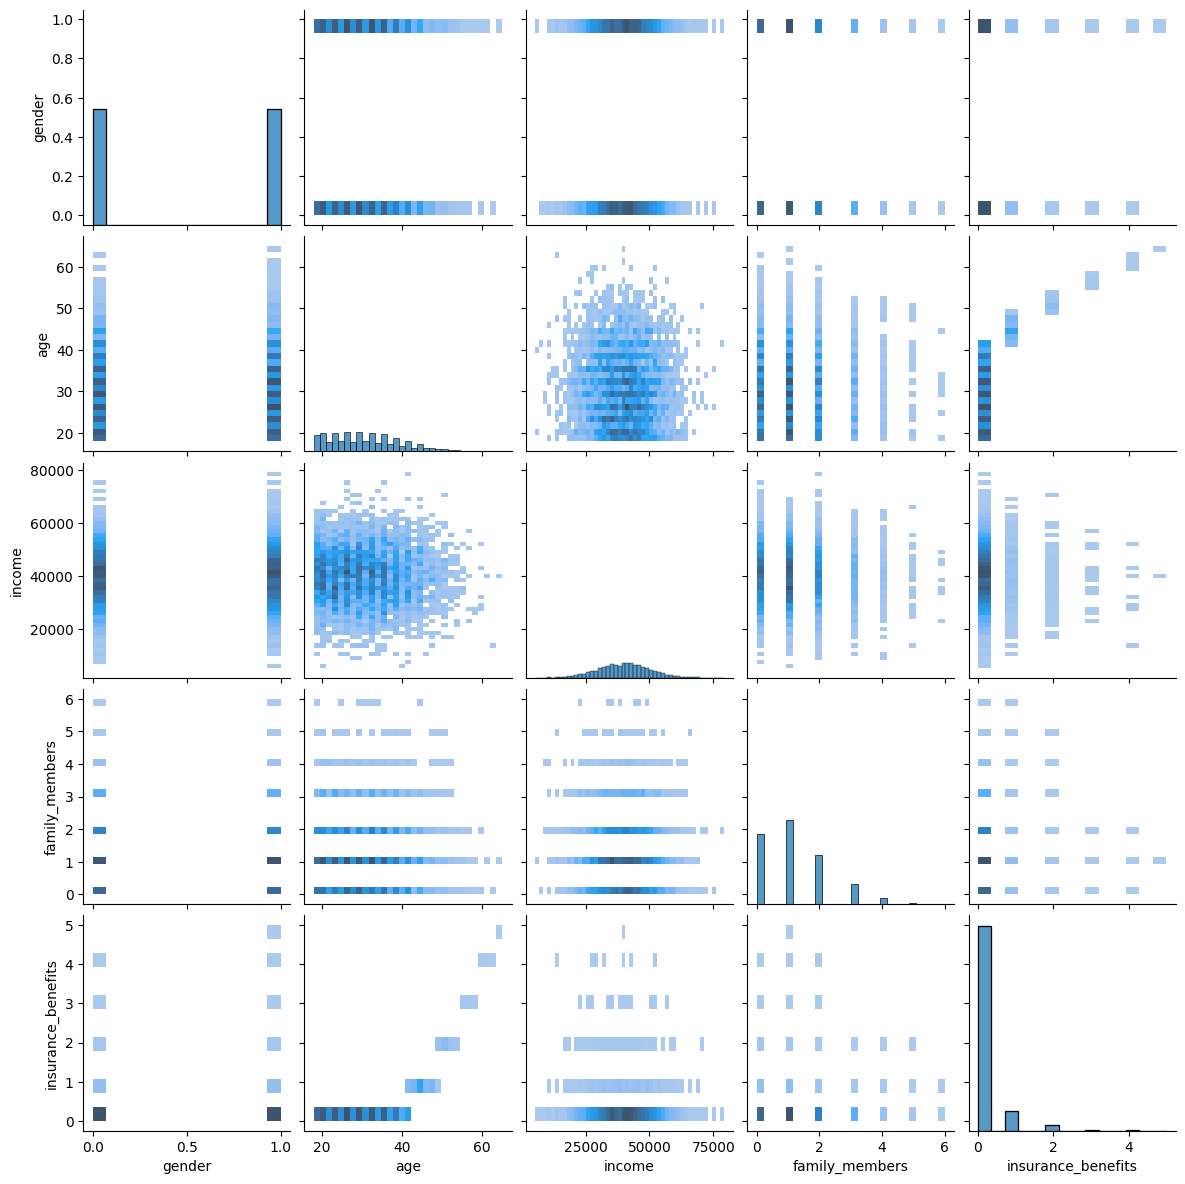

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Se procede a escribir una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.

Se probará para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador 
- Métricas de distancia
  - Euclidiana
  - Manhattan

¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param n: número de objetos para los que se buscan los vecinos más cercanos    
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    
    """

    nbrs = sklearn.neighbors.NearestNeighbors( n_neighbors = n, metric =  metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [16]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4126,1.0,0.553846,0.458228,0.166667,0
2395,0.0,0.476923,0.370886,0.500000,0
3034,1.0,0.523077,0.750633,0.166667,0
4600,0.0,0.553846,0.605063,0.333333,0
4672,0.0,0.400000,0.286076,0.166667,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

Distacia euclidea sin esacalr los datos

In [17]:
get_knn(df, 25, 5, 'euclidean')

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
25,1,47,38400.0,3,1,0.000000
375,1,46,38400.0,1,1,2.236068
1654,0,44,38400.0,1,1,3.741657
4581,1,41,38400.0,1,0,6.324555
318,0,41,38400.0,1,0,6.403124


Distancia euclidea con los objetos escalados

In [18]:
get_knn(df_scaled, 25, 5, 'euclidean')

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
25,1.0,0.723077,0.486076,0.5,1,0.000000
954,1.0,0.707692,0.508861,0.5,1,0.027492
2491,1.0,0.676923,0.482278,0.5,1,0.046310
936,1.0,0.692308,0.435443,0.5,1,0.059249
4197,1.0,0.753846,0.432911,0.5,1,0.061427


Distancia de Manhattan con el DataFrame sin escalar

In [19]:
get_knn(df, 25, 5, 'cityblock')

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
25,1,47,38400.0,3,1,0.0
375,1,46,38400.0,1,1,3.0
1654,0,44,38400.0,1,1,6.0
4581,1,41,38400.0,1,0,8.0
706,1,40,38400.0,1,0,9.0


Distancia de Manhattan con el DataFrame escalado

In [20]:
get_knn(df_scaled, 25, 5, 'cityblock')

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
25,1.0,0.723077,0.486076,0.5,1,0.000000
954,1.0,0.707692,0.508861,0.5,1,0.038169
2491,1.0,0.676923,0.482278,0.5,1,0.049951
936,1.0,0.692308,0.435443,0.5,1,0.081402
4197,1.0,0.753846,0.432911,0.5,1,0.083934


### **Conclusión intermedia**

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Como se observa, el hecho de escalar los datos en este caso nos permite encontrar personas que tiene el mismo `insurance_benefits` Así como un promedio de miembro de la familia `family_members` y el género a la perfección, variando las edades y el ingreso de esas personas, siendo estos similares entre si. Haciendo alusión a que estas perosnas son bastante semejantes.

Sin embargo, al no escalar los datos, es como si colocasemos un filtro por el ingreso total, ya que al ser el valor má grande, el algoritmo lo toma con más peso, y no nos permite tener otro tipo de información sobre las personas.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

En este caso, son igual de precisos ambos algoritmos, ya que arrojan a las mismas personas en ambos casos

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Se procede a contruir un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn 
- Luego se construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [21]:
def clasificacion(valor):
  if valor >= 1:
    v = 1
  else:
    v = 0
  return v

In [22]:
# сalcula el objetivo
df['insurance_benefits_received'] = list(map(lambda v: clasificacion(v) ,df['insurance_benefits']))

In [23]:
# comprueba el desequilibrio de clases con value_counts()

df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [24]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [25]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [26]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



### **Conclusión intermedia**

Como se puede observar, la calidad el modelo es baja, con un F1 entono al 12% y 20% lo cual no nos brinda demasiada información y no es lo suficientemente preciso. Se puede decir que en este caso el modelo predictivo no funciona mejor que el Dummy, será mejor optar por la regresión lineal para aumentar el valor de F1

Se repite el procedimeinto con los datos escaldos

In [27]:
# сalcula el objetivo
df_scaled['insurance_benefits_received'] = list(map(lambda v: clasificacion(v) ,df_scaled['insurance_benefits']))

In [28]:
for P in [0, df_scaled['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df_scaled['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



Como se observa se obtuvieron los mismos resultados que para el caso anterior con los datos sin escalar

Ahora para comparar, se procede a realizar un algoritmo de ML el cual nos permite obtener los KNN y así determinar que modelo es más efectivo según la F1_score, el cual es una representación de la exactitud y la sensibilidad del mismo.

Primeramente se implementa un modelo por emdio de la lubrería de Sklearn, utilizando lel df sin escalr y luego el escalado.

In [32]:
 def eval_classifi2(y_true, y_pred):
    
      f1_score_2 = sklearn.metrics.f1_score(y_true, y_pred, average = 'micro')
      print(f'F1: {f1_score_2:.2f}\n')
      
      cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
      print('Matriz de confusión')
      print(cm)

In [34]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

model = sklearn.neighbors.KNeighborsClassifier()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

eval_classifi2(y_test, y_pred)

F1: 0.90

Matriz de confusión
[[8.86666667e-01 4.66666667e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.80000000e-02 1.06666667e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.26666667e-02 3.33333333e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.66666667e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.66666667e-04 6.66666667e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]


In [35]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

model = sklearn.neighbors.KNeighborsClassifier()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

eval_classifi2(y_test, y_pred)

F1: 0.97

Matriz de confusión
[[8.86666667e-01 4.66666667e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.26666667e-02 6.60000000e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.00000000e-02 1.60000000e-02 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 6.66666667e-04 2.00000000e-03 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.33333333e-03 0.00000000e+00
  0.00000000e+00]]


Como se observa al escalr los datos se obtuvo un valor luego del entrenamiento del 97% un valor bastante alto y muy bueno para poder predecir si se le va o no a  otrogar el presta al cliente. En una escala del 0 al 5.

A continuación se pone a prueba una implementación propia por medio del calculo de la distancia eclidea

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

def nearest_neighbor_predict(train_features, train_target, new_features):
    distances = []
    for i in range(train_features.shape[0]):
        vector = train_features.loc[i].values
        distances.append(distance.euclidean(new_features, vector))
        
    best_index = np.array(distances).argmin()
    return int(train_target.loc[best_index,:])


class NearestNeighborClassifier():
    def fit(self, train_features, train_target):
        self.train_features = train_features
        self.train_target = train_target

    def predict(self, new_features):
        values = []
        for i in range(new_features.shape[0]):
            values.append(nearest_neighbor_predict(self.train_features, self.train_target, new_features.loc[i]))
        return pd.Series(values)
        
    def eval_classifier_2(self, y_true, y_pred):
    
        f1_score_2 = sklearn.metrics.f1_score(y_true, y_pred, average = 'micro')
        print(f'F1: {f1_score_2:.2f}\n')
        
        cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
        print('Matriz de confusión')
        print(cm)

model = NearestNeighborClassifier()
model.fit(pd.DataFrame(X_train), pd.DataFrame(y_train))
new_predictions = model.predict(pd.DataFrame(X_test))
model.eval_classifier_2(y_test, np.array(new_predictions))
print('\n')

F1: 0.91

Matriz de confusión
[[8.71333333e-01 2.00000000e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.33333333e-02 3.13333333e-02 4.00000000e-03 0.00000000e+00
  0.00000000e+00]
 [7.33333333e-03 1.33333333e-02 5.33333333e-03 0.00000000e+00
  0.00000000e+00]
 [1.33333333e-03 6.66666667e-04 6.66666667e-04 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.33333333e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]




In [ ]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

def nearest_neighbor_predict(train_features, train_target, new_features):
    distances = []
    for i in range(train_features.shape[0]):
        vector = train_features.loc[i].values
        distances.append(distance.euclidean(new_features, vector))
        
    best_index = np.array(distances).argmin()
    return int(train_target.loc[best_index,:])


class NearestNeighborClassifier():
    def fit(self, train_features, train_target):
        self.train_features = train_features
        self.train_target = train_target

    def predict(self, new_features):
        values = []
        for i in range(new_features.shape[0]):
            values.append(nearest_neighbor_predict(self.train_features, self.train_target, new_features.loc[i]))
        return pd.Series(values)
        
    def eval_classifier_2(self, y_true, y_pred):
    
        f1_score_2 = sklearn.metrics.f1_score(y_true, y_pred, average = 'micro')
        print(f'F1: {f1_score_2:.2f}\n')
        
        cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
        print('Matriz de confusión')
        print(cm)

model = NearestNeighborClassifier()
model.fit(pd.DataFrame(X_train), pd.DataFrame(y_train))
new_predictions = model.predict(pd.DataFrame(X_test))
model.eval_classifier_2(y_test, np.array(new_predictions))
print('\n')

F1: 0.98

Matriz de confusión
[[8.88666667e-01 2.66666667e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [4.66666667e-03 7.13333333e-02 2.66666667e-03 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.66666667e-03 2.00000000e-02 1.33333333e-03
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.33333333e-03 6.66666667e-04
  6.66666667e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.33333333e-03]]




### **Conclusión intermedia**

Como se puede observar, este modelo permite tener una presición por medio del índice F1 del 91% y 98% un poco mayor incluso que el de sklearn, con los datos sin escalar y escaldos respectivamente, demostrando que utilizando un modelo de KNN podebos obtener muy buenos resultados, muy superiores a los que se pueden obtener por medio de una probabilidad Dummy. 

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.


Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [ ]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = (np.linalg.inv(X.T @ X) @ X.T) @ y


    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X.dot(self.weights)
        
        return y_pred

In [ ]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 2.34323815e-02 -4.11580814e-02 -1.19007179e-05 -4.53191847e-02]
RMSE: 0.38
R2: 0.56


In [ ]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 1.52310479 -0.04115808 -0.94015671 -0.27191511]
RMSE: 0.38
R2: 0.56


### **Conclusión intermedia**

Como se observa, el modelo de regresión lineal nos permite obtener un resultado el cual tiene un RMSE = 38 % lo cual es un valor bastante aceptable, del mismo modo su R2 = 56 % la cual se encuentra tambiémn en buen valor.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [ ]:
P_inv = np.linalg.inv(P)
P_inv

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [ ]:
pd.DataFrame(P @ P_inv)

,0,1,2,3
0,1.000000e+00,-1.698486e-16,-7.581230e-17,-1.131125e-16
1,-6.948954e-17,1.000000e+00,-7.105687e-17,3.590970e-17
2,-1.212693e-16,-8.014613e-17,1.000000e+00,4.307640e-19
3,-3.606945e-16,-5.554302e-16,3.080724e-16,1.000000e+00


Se compruba que es inversa uya que s e obtiene la matriz identidad, como se puede ver los valores al rededor de la dagonal princpal son practicamente 0.

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

La función de `sklearn` utilizada para poder escalar los datos `sklearn.preprocessing.MaxAbsScaler()` Lo que hace es tomar el número más alto de esa columna, y dividir todo los datos entre este, ya que de esta manera toos los valores se encontrarán entre 0 y 1, en cada una de las columnas. Por lo tanto lo que se debe hacer es ubicar dicho valor y multiplicar la columna escalada para así obbtener los valores olriginales

Probando con la columna de `'age'`

In [ ]:
df['age'].max()

65

In [ ]:
df_scaled.loc[3,'age']

0.3230769230769231

In [ ]:
df_scaled.loc[3,'age']*65

21.0

In [ ]:
df.loc[3,'age']

21

Se comprueba que funciona para un nvalore de la tabla, ahora comprobemos para todos los valores de la columna

In [ ]:
df[df['age'] == df_scaled['age']*df['age'].max()]

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0
...,...,...,...,...,...,...
4995,0,28,35700.0,2,0,0
4996,0,34,52400.0,1,0,0
4997,0,20,33900.0,2,0,0
4998,1,22,32700.0,3,0,0


Como se observa se retornó el data Frame con las 5.000 columnas orignales, pudiendo concluir que si es posible obtener los valores origiales luego de escalarlos, ya que ocn cluaqier otro número obtendremos un data Frame vacio, tal como se ve a continuación

In [ ]:
df[df['age'] == df_scaled['age']*20]

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received


Se repite el proceso con `'income'`

In [ ]:
df[df['income'] == df_scaled['income']*df['income'].max()]

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0
5,1,43,41000.0,2,1,1
...,...,...,...,...,...,...
4995,0,28,35700.0,2,0,0
4996,0,34,52400.0,1,0,0
4997,0,20,33900.0,2,0,0
4998,1,22,32700.0,3,0,0


Como se observa, aquí si se obtuvo cierta perdida de datos, y esto es debido a los decimales, los cuales hacen que cirtos valores al redondearse no sean iguals, y al intentar devolverlos, se pierden

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [ ]:
X2 = X @ P
X2

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

In [ ]:
pd.DataFrame(X) == round(pd.DataFrame(X2 @ P_inv),2)

,0,1,2,3
0,True,True,True,True
1,True,True,True,True
2,True,True,True,True
3,True,True,True,True
4,True,True,True,True
...,...,...,...,...
4995,True,True,True,True
4996,True,True,True,True
4997,True,True,True,True
4998,True,True,False,True


Como se observa, Podemos obtener una buena aproximación de los valores originales, al multiplicar por la iversa de la matriz por la cual se ha multiplkicado previamente en este caso la inversa de P

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [ ]:
pd.DataFrame(X).head(10)

,0,1,2,3
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
5,1.0,43.0,41000.0,2.0
6,1.0,39.0,39700.0,2.0
7,1.0,25.0,38600.0,4.0
8,1.0,36.0,49700.0,1.0
9,1.0,32.0,51700.0,1.0


In [ ]:
round(pd.DataFrame(X2 @ P_inv),2).head(10)

,0,1,2,3
0,1.0,41.0,49600.0,1.0
1,-0.0,46.0,38000.0,1.0
2,-0.0,29.0,21000.0,0.0
3,-0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,-0.0
5,1.0,43.0,41000.0,2.0
6,1.0,39.0,39700.0,2.0
7,1.0,25.0,38600.0,4.0
8,1.0,36.0,49700.0,1.0
9,1.0,32.0,51700.0,1.0


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Debido al redondeo, podemos observar que existe una ligera desviación de los datos, sin embargo, los mismos fueros retornados de forma que pueden ser nuevamnente interpretados por la persoa la cual vay a tratarlos

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Ahora se procede a demostrar  _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. 

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?


**Respuesta**

Primeramenete, al ofuscar los datos, lo que se hace practicamente es una encriptación, la cual no permite que sea sencillo obtener los datos originales, ya que al la matriz cuadrada por la cual se multiplican los valores eer aleatoria debees encontrar la inversa antes de tan siquiera poder desenciptar, y la combinaciones son infinitas.

$w_P$ no es más que un aversión escalada de $w$, es un número multiplicado y aumentao por otra cierta cantidad de números los cuales nosotros como desarrolladores xconocemos que matematicamente no es más qaue el mismo número solo que se escribe de forma distinta al haber sido transformado.

Los valores predichos con $w_P$ no son mas que los mismos valores que se pueden predecir con $w$ solo que el peso ahora se ajusta por medio de una ofuscación, es decir se encripta, por tanto la regresión lineal ahora orrojará los valores escalados en P. Sin embar no debería de afecatr las métricas ya que es el equivalente a decir [1,2,3,4,5] * 5 = [5,10,15,20,25] Son los mismos números incrementados en 5, al divdir entre este, obtenemos los valores originales.



**Matemáticamente sería:**

Partimos de $w$ donde:
$$
w = (X^T X)^{-1} X^T y 
$$

Así mismo $w_p$ puede escribirse como:
$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Aplicando las propiedades de multiplicación de transpuestas queda:
$$
w_P = [(P^T X^T)  XP]^{-1} P^T X^T y
$$



Sacando factores comunes tenemos que:
$$
w_P = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty
$$




Pro propiedades de las matrices el producto punto de una matriz por su inversa será igual a la matriz identidad, que entermino de matrices, es el equivalente a multiplicar por 1 en el mundo de lso reales, por lo que se puede simplificar de tal forma que:

$$
w_P = P^{-1} (X^T  X)^{-1} X^T y
$$

Y como se observa todo lo del lado derecho de la ecuación es $w$, concluyendo que:

$$
w_P = P^{-1} w
$$

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible. Para ello se va a multiplicar dicha matriz cuadrada por su inversa, para detemrinar i el resultado es la matriz identidad.
- Utiliza $XP$ como la nueva matriz de características

In [ ]:
P2 = rng.random(size=(X.shape[1], X.shape[1]))

In [ ]:
P2_inv = np.linalg.inv(P2)

In [ ]:
round(pd.DataFrame(P2 @ P2_inv),2)

,0,1,2,3
0,1.0,0.0,0.0,-0.0
1,0.0,1.0,0.0,0.0
2,0.0,-0.0,1.0,-0.0
3,0.0,0.0,0.0,1.0


Habiendo comprobado que P2 es invertible, se procede a construir la matriz XP2

In [ ]:
class MyLinearRegressionObfuscated:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y, P):
        
        # añadir las unidades
        XP2 = X @ P2
        X = np.append(np.ones([len(XP2), 1]), XP2, axis=1)
        self.weights = (np.linalg.inv(XP2.T @ XP2) @ XP2.T) @ y


    def predict(self, X):
        XP2 = X @ P2
        # añadir las unidades
        X2 = np.append(np.ones([len(XP2), 1]), XP2, axis=1)
        y_pred = XP2.dot(self.weights)
        
        return y_pred

# Conclusiones

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegressionObfuscated()

lr.fit(X_train, y_train, P2)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.00024888 -0.12179482  0.15757904 -0.02828188]
RMSE: 0.38
R2: 0.56


In [ ]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegressionObfuscated()

lr.fit(X_train, y_train, P2)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[  5.89524504 -10.91870595   5.9359802    4.53868632]
RMSE: 0.38
R2: 0.56


### **Conclusión Intermedia**

Como se puede observar, Los valores obtenidos fueron exactamente los mismos que al no ofuscar los datos, por lo que s epuede decir que de esta amnera podemos  proteger los datos de cliente y de igual manera prdecir con un  38% de error si le podemos otorgar o no a nuetros un credito o no, sin que la ofuscación afecte las características del modelo original.

### **Conclusión General**

Como se pudo evidenciar, Se logró con exito generar un código que permitiese encontrar n cantidad de clientes similares, pudiendo incluso determinar la distancia Euclidea o de Manhathan que habia entre cada uno de los prospectos.

Del mismo modo, se realizó un estudio de probailidad para determiar si es probable que aun cliente se le diese o no un prestamo, llegando a la conlcusión que lo mejor era utilizar un algoritmo de machinelarnin que nos permitiese ser más precisos en dicha tarea.

Del mismo modo se creó un algoritmo de regresión lineal el cual permite predecir si al cliente se le vá a otorgar dicho prestamo o no, basado en todas las características del odelo escalado. 

Por último, fue posible diseñar el mismo modelo, pudiendo predecir los valores de igual manera, pretegiendo la información de lso cleinte por medio de la ofuscación de lso datos. Sin tener singuna diferencia significativa entre ofuscalos o no, protegiendo así toda la información de nustros clientes.